## Initial analysis

In [1]:
# Install the required libraries (from pip_requirements.txt)
%pip install -r pip_requirements.txt

!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------- ------------------------------ 3.1/12.8 MB 16.8 MB/s eta 0:00:01
     ------------------- -------------------- 6.3/12.8 MB 15.4 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 15.5 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 16.1 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 13.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Modules to import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from importlib import reload
import plotly.graph_objects as go
import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd


In [4]:
paths = ['src/data','src/models','src/scripts','src/utils']
for path in paths:
    sys.path.append(path)

## I. Data preprocessing

### I.1 Original data

In [5]:
# Execute dataCleaning.py
%run src/scripts/dataCleaning.py

Movies successfully loaded
Characters successfully loaded
Clusters successfully loaded
Summaries successfully loaded
Dates successfully converted
Build of countries dictionnary...
Build of languages dictionnary...
Build of genres dictionnary...
Build of actors dictionnary...
Build of character dictionnary...
Build of movies dictionnary...
Dictionnaries successfully saved
Saved movies_cleaned to data/cleanData/movies_cleaned.csv
Saved characters_cleaned to data/cleanData/characters_cleaned.csv
Saved character_clusters_cleaned to data/cleanData/character_clusters_cleaned.csv
Saved summaries_cleaned to data/cleanData/summaries_cleaned.csv
Datasets successfully saved
Data cleaning successfully done


Load the data

In [6]:
# Import dataloader function
from dataLoader import loadDataframe

In [7]:
# Load data
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/data\dataLoader.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_convert] = df[columns_to_convert].applymap(eval)


### I.2 Additional data

#### I.2.1 Additional movie dataset from Kaggle

Because the revenue is important for the Economics part of our analysis we try to add a new dataset from Kaggle with movies to add more consistency to our results.

The new dataset has the revenue and the budget as interesting features for the Economics analysis.

In [8]:
#Execute additionaldataCleaning.py
%run src/scripts/additionaldataCleaning.py

Additional Movies successfully loaded
Monthly inflation data successfully loaded
Budget successfully converted
Filtered additional movie data successfully created
Inflation data successfully processed
Saved Kaggle_US_CPI_monthly_cleaned to data/cleanData/Kaggle_US_CPI_monthly_cleaned.csv
Saved monthly inflation data to Kaggle_US_CPI_monthly_cleaned.csv
Saved Kaggle_US_CPI_annual_cleaned to data/cleanData/Kaggle_US_CPI_annual_cleaned.csv
Saved annual inflation data to Kaggle_US_CPI_annual_cleaned.csv
Saved Kaggle_movie_data_tmdb_cleaned to data/cleanData/Kaggle_movie_data_tmdb_cleaned.csv
Saved additional movie data to Kaggle_movie_data_tmdb_cleaned.csv
Saved Kaggle_movie_data_tmdb_filtered_cleaned to data/cleanData/Kaggle_movie_data_tmdb_filtered_cleaned.csv
Saved filtered additional movie data to Kaggle_movie_data_tmdb_filtered_cleaned.csv


Data statistics overview

In [9]:
from dataLoader import loadAdditionalDataframe

In [10]:
path_to_directory = 'data/cleanData/'
df_inflation_additional_annual = loadAdditionalDataframe('inflation_annual', path_to_directory)
df_inflation_additional_monthly = loadAdditionalDataframe('inflation_monthly', path_to_directory)  
df_movies_additional = loadAdditionalDataframe('movies_additional', path_to_directory)
df_movies_additional_filtered = loadAdditionalDataframe('movies_additional_filtered', path_to_directory)

In [11]:
df_movies_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119931 entries, 0 to 119930
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   imdb_id            114475 non-null  object 
 1   original_title     119392 non-null  object 
 2   original_language  119392 non-null  object 
 3   budget             119074 non-null  float64
 4   revenue            119071 non-null  object 
 5   release_date       118642 non-null  object 
 6   title              118752 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.4+ MB


In [12]:
# Non null values proportion
df_movies_additional.isnull().mean()

imdb_id              0.045493
original_title       0.004494
original_language    0.004494
budget               0.007146
revenue              0.007171
release_date         0.010748
title                0.009831
dtype: float64

The features that we are interested in are the following:
- 'original_title' : more than 99% of the movies have a title
- 'revenue' : more than 99% of the movies have a revenue
- 'budget' : more than 99% of the movies have a budget

So we have a large amount of non null values that we can use to make our economics analysis.

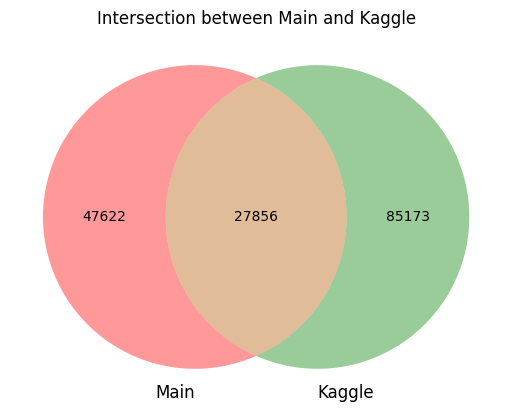

In [13]:
from generalUtils import intersectionId
intersectionId(df_movies, df_movies_additional, 'Main', 'Kaggle', id_column='original_title')

More than 27,000 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

In [14]:
df_movies_additional.loc[df_movies_additional['budget'] != 0].count()

imdb_id              14391
original_title       14504
original_language    14504
budget               14186
revenue              14496
release_date         14431
title                14178
dtype: int64

However, after a deeper analysis on the Kaggle dataset we realize that only ~14,000 values are not null for the budget and the revenue. So, a lot of implicit missing values were hidden in the Kaggle dataset.

In [15]:
# we load additional movie data from Kaggle where budget is not null
df_movies_additional_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15043 entries, 0 to 15042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_id            14391 non-null  object 
 1   original_title     14504 non-null  object 
 2   original_language  14504 non-null  object 
 3   budget             14186 non-null  float64
 4   revenue            14496 non-null  object 
 5   release_date       14431 non-null  object 
 6   title              14178 non-null  object 
dtypes: float64(1), object(6)
memory usage: 822.8+ KB


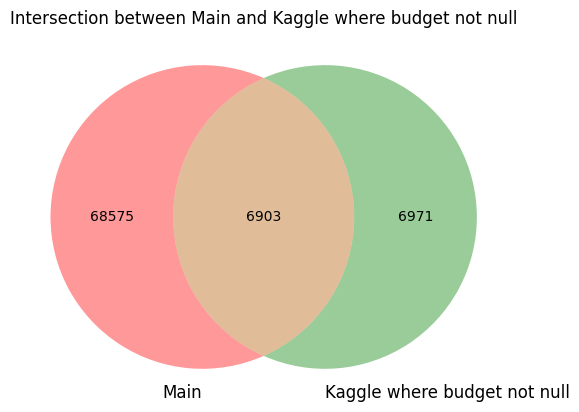

In [16]:
intersectionId(df_movies, df_movies_additional_filtered, 'Main', 'Kaggle where budget not null', id_column='original_title')

Finally, we realize that only 6,903 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

This is much lower than we had hoped, which makes the dataset irrelevant in our case, as the feature revenue of the original dataset had 8401 non-zero values.

### I.2.2 Inflation dataset from Kaggle

Because we are going to study the revenue of movies it is also important to consider the Inflation by importing a dataset from Kaggle. Without adjusting for inflation, raw revenue data can be misleading, underestimating or overestimating the relative success of films from past eras. Adjusting for inflation makes analyses much more relevant and nuanced for understanding the evolution of the film industry. We make the assumption that the Consumer Price Index of the USA is representative of the rest of the world.

In [17]:
df_inflation_additional_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Yearmon  1296 non-null   datetime64[ns]
 1   CPI      1296 non-null   float64       
 2   year     1296 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 25.4 KB


In [18]:
df_inflation_additional_annual.describe()

,year,CPI
count,108.00000,108.000000
mean,1966.50000,81.641431
std,31.32092,79.760606
min,1913.00000,9.883333
25%,1939.75000,17.495833
50%,1966.50000,32.908333
75%,1993.25000,145.400000
max,2020.00000,258.811167


The annual inflation dataset from 1913 to 2020 will be used to readjust the revenue of movies considering the year of release.

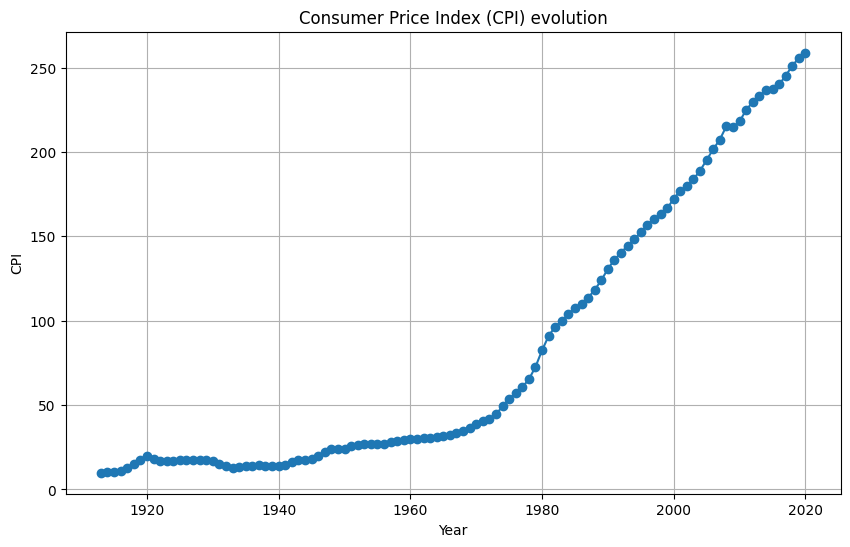

In [19]:
# plot the temporal evolution of the Consumer Price Index (CPI)
plt.figure(figsize=(10, 6))
plt.plot(df_inflation_additional_annual['year'], df_inflation_additional_annual['CPI'], marker='o')
plt.title('Consumer Price Index (CPI) evolution')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.grid()
plt.show()


## III. Economic

### III.1 Dataframe for Economic part

For the Economic Part, we process the data as following:

- We select relevant columns by keeping only the necessary columns related to movie details and revenue.

- We filter the data to focus on relevant movies by removing missing revenue values

- We notice the income values in the orignal dataset range from 1897 to 2012 with only one value in 1897. So, considering the CPI dataset ranges from 1913 to 2020, we remove the first revenue value to be consistent.

- We calculate the income reindexed for inflation, using the midpoint year between 2012 and 1913 as a reference year (1963 in this case) to minimize edge effects.


In [20]:
# We import the dataframe for Economics part
from scriptEconomy import process_data_economy

df_movies_eco = process_data_economy()

df_movies_eco.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_movies[columns_to_convert] = df_movies[columns_to_convert].applymap(eval) # Convert the columns with list of strings to list of strings
c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_eco['year'] = df_movies_eco['release_date'].dt.year # Extract the year from the 'release_date' column


,wiki_id,freebase_id,original_title,release_date,revenue,countries,countries_freebase_id,year,revenue_adj
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,[United States of America],[/m/09c7w0],2001.0,2.423278e+06
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,[United States of America],[/m/09c7w0],1938.0,7.823773e+06
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,[United Kingdom],[/m/07ssc],1989.0,2.510220e+06
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,[United States of America],[/m/09c7w0],1964.0,1.009813e+08
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,[United States of America],[/m/09c7w0],1999.0,3.956660e+03
29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,[United States of America],[/m/09c7w0],2001.0,5.081775e+06
36,1364293,/m/04wy0v,They Knew What They Wanted,1940-01-01,932000.0,[United States of America],[/m/09c7w0],1940.0,2.037537e+06
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980-01-01,34331783.0,[South Africa],[/m/0hzlz],1980.0,1.275855e+07
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,"[Mexico, United States of America]","[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06
54,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989-01-01,3416846.0,[United States of America],[/m/09c7w0],1989.0,8.441052e+05


In [21]:
df_movies_eco.describe()

,wiki_id,release_date,revenue,year,revenue_adj
count,8.327000e+03,8327,8.327000e+03,8327.000000,8.327000e+03
mean,8.987038e+06,1991-07-03 00:31:18.035306880,4.826907e+07,1991.067371,1.053456e+07
min,3.217000e+03,1914-02-15 00:00:00,1.000000e+04,1914.000000,1.404459e+03
25%,1.210197e+06,1985-01-01 00:00:00,2.105039e+06,1985.000000,8.739525e+05
50%,4.032619e+06,1997-09-06 00:00:00,1.081538e+07,1997.000000,2.935405e+06
75%,1.485150e+07,2006-06-23 00:00:00,4.105011e+07,2006.000000,9.664270e+06
max,3.706127e+07,2012-10-25 00:00:00,2.782275e+09,2012.000000,8.857474e+08
std,1.013294e+07,NaN,1.124673e+08,19.703164,2.670217e+07


Finally, the Economic analysis is conducted on a sample of 8327 movies.






### III.2 Free exchange of goods and services

Plot of the Revenue vs. Adjusted Revenue Over the Years:

- We creates a dual-axis plot for revenue and adjusted revenue over the years in billions

In [40]:
# Calculate the necessary data
revenue = df_movies_eco.groupby('year')['revenue'].sum() / 10**9
revenue_adj = df_movies_eco.groupby('year')['revenue_adj'].sum() / 10**9

# Create a Plotly figure
fig = go.Figure()

# Add the 'Revenue' curve
fig.add_trace(go.Scatter(
    x=revenue.index,
    y=revenue,
    mode='lines',
    name='Revenue in billion $',
    line=dict(color='darkblue'),
    yaxis='y1'
))

# Add the 'Adjusted Revenue' curve
fig.add_trace(go.Scatter(
    x=revenue_adj.index,
    y=revenue_adj,
    mode='lines',
    name='Adjusted Revenue in billion $',
    line=dict(color='darkorange'),
    yaxis='y2'
))

# Configure the layout
fig.update_layout(
    title=dict(
        text='Revenue vs. Adjusted Revenue Over the Years Worldwide',
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(title='Year'),
    yaxis=dict(
        title='Revenue in billion $',
        titlefont=dict(color='darkblue'),
        tickfont=dict(color='darkblue'),
        side='left'
    ),
    yaxis2=dict(
        title='Adjusted Revenue in billion $',
        titlefont=dict(color='darkorange'),
        tickfont=dict(color='darkorange'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.5, y=1, xanchor='center', orientation='h')
)

# Display the chart
fig.show()
fig.write_html("Rev_vs_Adj_Rev_Worldwide.html")


From the previous plot we observe that the computation of the value of revenue adjusted for inflation is an essential indicator for correctly interpreting the evolution of film revenues over a long period, in the context of the film industry from 1914 to 2012. we can confirm that using 1963 as the reference year helps to minimize potential edge effects that might have appeared if a more recent or much older year were used.

Finally, we can state that it is possible to address the Economic Part, by examining the box office revenue of films over time.

Datframe of the exploded Economic dataset on country feature: 

**We assume that for co-productions, the film's revenues are shared by all the countries that co-produced the film.**

- We create duplicates of the rows with multiple production countries. 

- We remove the rows with no countries

- We attach a world region to each country


In [23]:
reload(sys.modules['scriptEconomy']) 
# We import the dataframe for Exploded Economic part
from scriptEconomy import process_data_exploded_economy

df_movies_eco_exploded_countries = process_data_exploded_economy()

df_movies_eco_exploded_countries.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_movies[columns_to_convert] = df_movies[columns_to_convert].applymap(eval) # Convert the columns with list of strings to list of strings
c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_eco['year'] = df_movies_eco['release_date'].dt.year # Extract the year from the 'release_date' column


,wiki_id,freebase_id,original_title,release_date,revenue,countries,countries_freebase_id,year,revenue_adj,region
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,United States of America,[/m/09c7w0],2001.0,2.423278e+06,North America
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,United States of America,[/m/09c7w0],1938.0,7.823773e+06,North America
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,United Kingdom,[/m/07ssc],1989.0,2.510220e+06,Europe
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,United States of America,[/m/09c7w0],1964.0,1.009813e+08,North America
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,United States of America,[/m/09c7w0],1999.0,3.956660e+03,North America
29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,United States of America,[/m/09c7w0],2001.0,5.081775e+06,North America
36,1364293,/m/04wy0v,They Knew What They Wanted,1940-01-01,932000.0,United States of America,[/m/09c7w0],1940.0,2.037537e+06,North America
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980-01-01,34331783.0,South Africa,[/m/0hzlz],1980.0,1.275855e+07,Africa
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,Mexico,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,United States of America,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America


In [24]:
df_movies_eco_exploded_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10985 entries, 0 to 81726
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                10985 non-null  int64         
 1   freebase_id            10985 non-null  object        
 2   original_title         10985 non-null  object        
 3   release_date           10985 non-null  datetime64[ns]
 4   revenue                10985 non-null  float64       
 5   countries              10985 non-null  object        
 6   countries_freebase_id  10985 non-null  object        
 7   year                   10985 non-null  float64       
 8   revenue_adj            10985 non-null  float64       
 9   region                 10985 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 944.0+ KB


Interactive plot of the Revenue vs Adjusted Revenue Over the Years per Country:

- We create a dual-axis plot for revenue and adjusted revenue over the years per country using plotly library.

- We can select the country on which we want to filter on.

In [25]:
# Create a plotly figure
fig = go.Figure()
df_movies_eco_exploded_countries['countries'] = df_movies_eco_exploded_countries['countries'].astype(str)

# Add traces for each country's data
for i, country in enumerate(df_movies_eco_exploded_countries['countries'].unique()):
    country_data = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == country].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

    # Add Revenue trace
    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['revenue'],
        mode='lines+markers',
        name=f'Revenue ({country}) in $',
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='circle'),
        yaxis='y'  # Use the primary y-axis
    ))

    # Add Adjusted Revenue trace
    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['revenue_adj'],
        mode='lines+markers',
        name=f'Adjusted Revenue ({country}) in $',
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='square'),
        yaxis='y2'  # Use the secondary y-axis
    ))

# Create dropdown buttons for filtering by country
buttons = []
for country in df_movies_eco_exploded_countries['countries'].unique():
    visibility = [country == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

    button = {
        'label': country,
        'method': 'update',
        'args': [
            {'visible': visibility},  # Update visibility of traces
            {'title': f"Revenue vs Adjusted Revenue: {country}"}
        ]
    }
    buttons.append(button)

# Update layout with dropdown menu and styling
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.5,
        'y': 1.15,
        'xanchor': 'center',
        'yanchor': 'top'
    }],
    title={
        'text': "Revenue vs Adjusted Revenue Over the Years per Country",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial, sans-serif')
    },
    xaxis=dict(
        title='Year',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='Adjusted Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        overlaying='y',
        side='right',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    legend=dict(
        title='Legend',
        x=0.01,
        y=0.99,
        bordercolor="Black",
        borderwidth=1,
        font=dict(size=12)
    ),
    plot_bgcolor='white'
)

# Add grid lines and background
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Show the figure
fig.show()
fig.write_html("Rev-vs-Adj_Rev_country.html")


Interactive plot of the Revenue vs Adjusted Revenue Over the Years per Region:

- We create a dual-axis plot for revenue and adjusted revenue over the years per region using plotly library.

- We can select the region on which we want to filter on.

In [26]:
# Create a plotly figure
fig = go.Figure()
df_movies_eco_exploded_countries['region'] = df_movies_eco_exploded_countries['region'].astype(str)

# Add traces for each region's data
for i, region in enumerate(df_movies_eco_exploded_countries['region'].unique()):
    region_data = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['region'] == region].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

    # Add Revenue trace
    fig.add_trace(go.Scatter(
        x=region_data['year'],
        y=region_data['revenue'],
        mode='lines+markers',
        name=f'Revenue ({region}) in $',
        visible=True if region == df_movies_eco_exploded_countries['region'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='circle'),
        yaxis='y'  # Use the primary y-axis
    ))

    # Add Adjusted Revenue trace
    fig.add_trace(go.Scatter(
        x=region_data['year'],
        y=region_data['revenue_adj'],
        mode='lines+markers',
        name=f'Adjusted Revenue ({region}) in $',
        visible=True if region == df_movies_eco_exploded_countries['region'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='square'),
        yaxis='y2'  # Use the secondary y-axis
    ))

# Create dropdown buttons for filtering by region
buttons = []
for region in df_movies_eco_exploded_countries['region'].unique():
    visibility = [region == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

    button = {
        'label': region,
        'method': 'update',
        'args': [
            {'visible': visibility},  # Update visibility of traces
            {'title': f"Revenue vs Adjusted Revenue: {region}"}
        ]
    }
    buttons.append(button)

# Update layout with dropdown menu and styling
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.5,
        'y': 1.15,
        'xanchor': 'center',
        'yanchor': 'top'
    }],
    title={
        'text': "Revenue vs Adjusted Revenue Over the Years per Region",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial, sans-serif')
    },
    xaxis=dict(
        title='Year',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='Adjusted Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        overlaying='y',
        side='right',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    legend=dict(
        title='Legend',
        x=0.01,
        y=0.99,
        bordercolor="Black",
        borderwidth=1,
        font=dict(size=12)
    ),
    plot_bgcolor='white'
)

# Add grid lines and background
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Show the figure
fig.show()
fig.write_html("Rev-vs-Adj_Rev_region.html")


Dataframe of the exploded Economic dataset on country feature aggregated on the revenue: 

- We group the dataset exploded on countries by year and country and we sum the revenue to calculate the total revenue per country and per year. 

- We also group the dataset exploded on countries by year and we add a feature with the total revenue per year.

- We add a feature with the market share per year of each country as a percentage.

- We add two features with the log of the revenue and the the log of the market share to underestimate the weight of the United States of America in the following plots.


In [27]:
reload(sys.modules['scriptEconomy']) 
# We import the dataframe aggregating the revenue per country

from scriptEconomy import calculate_market_share_economy

df_movies_eco_exploded_countries_agg = calculate_market_share_economy()

df_movies_eco_exploded_countries_agg.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,countries,revenue,total_revenue_year,market_share,log_revenue,log_market_share
0,1914,United States of America,2831728.0,2831728.0,100.000000,14.856398,4.605170
1,1915,United States of America,50000000.0,50000000.0,100.000000,17.727534,4.605170
2,1920,United States of America,4500000.0,4500000.0,100.000000,15.319588,4.605170
3,1921,United States of America,7900000.0,7900000.0,100.000000,15.882373,4.605170
4,1922,United States of America,17530973.0,17530973.0,100.000000,16.679480,4.605170
5,1923,United States of America,7668790.0,7668790.0,100.000000,15.852669,4.605170
6,1924,United States of America,2419827.0,2419827.0,100.000000,14.699207,4.605170
7,1925,United Kingdom,2000000.0,22262001.0,8.983918,14.508658,2.195436
8,1925,United States of America,20262001.0,22262001.0,91.016082,16.824258,4.511036
9,1926,United States of America,4000000.0,4000000.0,100.000000,15.201805,4.605170


Interactive map of the Market Share in terms of Revenue Worldwide Over the Years:

- We use plotly to create an interactive map representing the market share of each country per year.

- We use the log of the market share feature for the scale.

In [28]:
# Create the choropleth map
fig = px.choropleth(
    df_movies_eco_exploded_countries_agg,
    locations="countries",  # The column with the country names
    locationmode="country names",  # Use full country names
    color="log_market_share",  # The color scale corresponds to the market share
    animation_frame="year",  # Animation by year
    color_continuous_scale="Blues",  # Color scale
    range_color=[df_movies_eco_exploded_countries_agg["log_market_share"].min(), df_movies_eco_exploded_countries_agg["log_market_share"].max()],  # Fix scale range to min and max market share
    title="Market Share in terms of Revenue Worldwide per Year"
)

# Update the layout
fig.update_layout(
    geo=dict(
        showframe=False,
        projection_type='equirectangular'
    ),
    title_x=0.5
)

# Show the figure
fig.show()
fig.write_html("Rev_Market-share.html")



### III.3 Co-productions evolution

Exploded dataset on country feature of co-productions: 

- We create a list of the wiki_id for co-produced movies

- We create a new dataframe filtering only the co-productions movies. 


In [29]:
reload(sys.modules['scriptEconomy']) 
# We import the dataframe of co-productions
from scriptEconomy import movies_co_productions

df_movies_eco_exploded_countries_coprod = movies_co_productions()

df_movies_eco_exploded_countries_coprod.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,wiki_id,freebase_id,original_title,release_date,revenue,countries,countries_freebase_id,year,revenue_adj,region
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,Mexico,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,United States of America,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America
164,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,France,"[/m/0f8l9c, /m/087vz, /m/0345h]",1998.0,6.602769e+04,Europe
164,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,Slovenia,"[/m/0f8l9c, /m/087vz, /m/0345h]",1998.0,6.602769e+04,Europe
164,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,Germany,"[/m/0f8l9c, /m/087vz, /m/0345h]",1998.0,6.602769e+04,Europe
175,196176,/m/01bwgr,Straw Dogs,1971-11-03,11148828.0,United States of America,"[/m/09c7w0, /m/07ssc]",1971.0,8.432176e+06,North America
175,196176,/m/01bwgr,Straw Dogs,1971-11-03,11148828.0,United Kingdom,"[/m/09c7w0, /m/07ssc]",1971.0,8.432176e+06,Europe
197,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,South Korea,"[/m/06qd3, /m/0345h]",2003.0,1.585660e+06,East and Southeast Asia
197,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,Germany,"[/m/06qd3, /m/0345h]",2003.0,1.585660e+06,Europe
222,3033993,/m/08m1s2,Becoming Jane,2007-03-02,37311672.0,Ireland,"[/m/03rt9, /m/07ssc]",2007.0,5.511028e+06,Europe


Dataframe of the number of co-productions per country per year: 

- We group the dataset of co-produced movies on wiki_id by year and country and we count the number of co-productions per country.

In [30]:
reload(sys.modules['scriptEconomy']) 
# We import the dataframe of co_productions per country per year
from scriptEconomy import coprod_countries_yearly

df_movies_eco_coprod_countries_count = coprod_countries_yearly()

df_movies_eco_coprod_countries_count.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,countries,co_production_count
0,1925,United Kingdom,1
1,1925,United States of America,1
2,1930,Germany,1
3,1940,Malaysia,1
4,1940,United States of America,1
5,1942,United Kingdom,1
6,1942,United States of America,1
7,1945,United Kingdom,1
8,1950,United Kingdom,2
9,1950,United States of America,2


Plot of the Adjusted Revenue and Co-Productions Over the Years:

- We create a dual-axis plot for adjusted revenue and number of co-productions over the years per country using plotly library.

- We can select the country on which we want to filter on.

In [31]:
# Initialize figure
fig = go.Figure()
df_movies_eco_exploded_countries['countries'] = df_movies_eco_exploded_countries['countries'].astype(str)

# Add traces for each country's data
for i, country in enumerate(df_movies_eco_exploded_countries['countries'].unique()):
    country_data = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == country].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

    # Add Bar trace (with transparency)
    fig.add_trace(go.Bar(
        x=country_data['year'],
        y=df_movies_eco_coprod_countries_count['co_production_count'],  # Count of co-productions
        name=f'Co-productions ({country})',
        marker=dict(opacity=0.5),
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        yaxis='y2'  # Use the primary y-axis
    ))

    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['revenue_adj'],
        mode='lines+markers',
        name=f'Adjusted Revenue in $ ({country})',
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='square'),
        yaxis='y'  # Use the secondary y-axis
    ))

# Create dropdown buttons for filtering by country
buttons = []
for country in df_movies_eco_exploded_countries['countries'].unique():
    visibility = [country == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

    button = {
        'label': country,
        'method': 'update',
        'args': [
            {'visible': visibility},  # Update visibility of traces
            {'title': f"Adjusted Revenue and Co-Productions: {country}"}
        ]
    }
    buttons.append(button)

# Update layout with dropdown menu and styling
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.5,
        'y': 1.15,
        'xanchor': 'center',
        'yanchor': 'top'
    }],
    title={
        'text': "Adjusted Revenue and Co-Productions Over the Years",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial, sans-serif')
    },
    xaxis=dict(
        title='Year',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Adjusted Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        overlaying='y2',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='# Co-Productions',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        side='right',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    legend=dict(
        title='Legend',
        x=0.01,
        y=0.99,
        bordercolor="Black",
        borderwidth=1,
        font=dict(size=12)
    ),
    plot_bgcolor='white'
)

# Add grid lines and background
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Show the figure
fig.show()
fig.write_html("Rev_vs_Co-prod.html")

Dataframe of the number of co-productions per pair of country per year: 

- We use combinations from itertool library to generate all the combinations of countries per movies

- We count the number of co-productions per year and per couple of countries

In [32]:
reload(sys.modules['scriptEconomy']) 
# We import the dataframe of co_productions per pair of country per year
from scriptEconomy import coprod_couple_countries_yearly

df_movies_eco_coprod_country_country = coprod_couple_countries_yearly()

df_movies_eco_coprod_country_country.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,country_1,country_2,co_production_count
0,1925,United Kingdom,United States of America,1
1,1930,Germany,Germany,1
2,1940,Malaysia,United States of America,1
3,1942,United Kingdom,United States of America,1
4,1945,United Kingdom,United Kingdom,1
5,1950,United Kingdom,United States of America,2
6,1951,France,India,1
7,1951,France,United Kingdom,1
8,1951,France,United States of America,1
9,1951,India,United Kingdom,1


Interactive plot of the Co-productions Between Countries Over the Years:

- We use geopandas and plotly to create an interactive map linking countries by their number of co-productions. 

- We fix the centroids of some country for aesthetic reasons on the map.

- We can select the year on which we want to filter on.

In [33]:
# charging geographical data 
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# changing data into the right projection to compute the centroids
world_projected = world.to_crs("EPSG:3395")
world_projected["centroid"] = world_projected.geometry.centroid
world["centroid"] = world_projected["centroid"].to_crs(world.crs) # converting back the centroids into the right projection

# Linking each centroid with a country
centroids = world.set_index("NAME")["centroid"] 
df_movies_eco_coprod_country_country["coord1"] = df_movies_eco_coprod_country_country["country_1"].map(centroids)
df_movies_eco_coprod_country_country["coord2"] = df_movies_eco_coprod_country_country["country_2"].map(centroids)

#Fixing centroid of USA (without Alaska), Canada, Norway and France
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'United States of America', 'coord1'] = Point(-98.35, 39.50)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'United States of America', 'coord2'] = Point(-98.35, 39.50)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'Canada', 'coord1'] = Point(-105, 56.8)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'Canada', 'coord2'] = Point(-105, 56.8)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'Norway', 'coord1'] = Point(10, 62)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'Norway', 'coord2'] = Point(10, 62)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'France', 'coord1'] = Point(2.25, 46.32)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'France', 'coord2'] = Point(2.25, 46.32)

# Creating the figure
fig = px.scatter_geo(
    world,  # GeoDataFrame
    #locations="ISO_A3",  # countries id
    #hover_name="NAME",  # names to print
    title="Co-productions Between Countries Over the Years")

# Adding the links from df_movies_eco_coprod_country_country
traces = []
for year in df_movies_eco_coprod_country_country["year"].unique():
    df_year = df_movies_eco_coprod_country_country[df_movies_eco_coprod_country_country["year"] == year]
    df_year = df_year.dropna(subset=["coord1", "coord2"])

    trace = px.scatter_geo(
        world, # GeoDataFrame
        locations="ISO_A3",
        hover_name="NAME",
        title=f"Interactions between countries ({year})"
    )
    for _, row in df_year.iterrows():
        fig.add_scattergeo(
            lon=[row["coord1"].x, row["coord2"].x],
            lat=[row["coord1"].y, row["coord2"].y],
            mode="lines",
            line=dict(width=row["co_production_count"] / 30, color="blue"),
            name=f"{row['country_1']} ↔ {row['country_2']} ({row['year']})",
            opacity=1,
            showlegend=False
        )

    traces.append(trace)

# Adding a slider and centering the title
fig.update_layout(
    showlegend=False, 
    sliders=[
        dict(
            active=0,
            currentvalue={"prefix": "Year: "},
            pad={"t": 50},
            steps=[
                dict(
                    label=str(year),
                    method="update",
                    args=[{"visible": [i <= idx for i in range(len(traces))]}],
                )
                for idx, year in enumerate(df_movies_eco_coprod_country_country["year"].unique())
            ],
        )
    ],
    title={
        "text": "Co-productions Between Countries Over the Years",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top"
    }
)

fig.show()
fig.write_html("Co-prod_countries.html")



Dataframe of the number of co-productions per pair of country per period: 

- We use the dataframe of co-productions per pair of country per year

- We count the number of co-productions per period of 10 years and per couple of countries using group by function

In [34]:
reload(sys.modules['scriptEconomy']) 
# We import the dataframe of co_productions per pair of country per period
from scriptEconomy import coprod_couple_countries_period

df_movies_eco_coprod_country_country_10 = coprod_couple_countries_period()

df_movies_eco_coprod_country_country_10.head(10)


c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,period,country_1,country_2,co_production_count
0,1920,United Kingdom,United States of America,1
1,1930,Germany,Germany,1
2,1940,Malaysia,United States of America,1
3,1940,United Kingdom,United Kingdom,1
4,1940,United Kingdom,United States of America,1
5,1950,Australia,United Kingdom,1
6,1950,Belgium,United States of America,1
7,1950,France,India,1
8,1950,France,Italy,2
9,1950,France,United Kingdom,1


Dataframe of the revenue per country and per period: 

- We use the dataframe of the exploded Economic dataset on country feature.

- We group by period and country on the revenue using a sum aggregator.

- We add a feature with the log of the revenue to underestimate the weight of the United States of America in the following plot.


In [35]:
reload(sys.modules['scriptEconomy']) 
# We import the dataframe of the revenue per period
from scriptEconomy import revenue_period

df_movies_eco_exploded_countries_agg_10 = revenue_period()

df_movies_eco_exploded_countries_agg_10.head(10)


c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,period,countries,revenue,log_revenue_period
0,1910,United States of America,5.283173e+07,17.782622
1,1920,United Kingdom,2.000000e+06,14.508658
2,1920,United States of America,9.681659e+07,18.388329
3,1930,Germany,1.559640e+05,11.957380
4,1930,United Kingdom,3.252000e+06,14.994781
5,1930,United States of America,1.054904e+09,20.776715
6,1940,India,2.190000e+05,12.296827
7,1940,Italy,2.200000e+06,14.603968
8,1940,Malaysia,1.600000e+06,14.285514
9,1940,United Kingdom,1.777121e+07,16.693090


Interactive plot of the Revenue and Co-productions Between Countries Over the Periods:

- We use geopandas and plotly to create an interactive plot linking countries by their number of co-productions over the periods.

- We use plotly to add the revenue per country and per period.

- We fix the centroids of some country for aesthetic reasons on the map.

- We can select the period on which we want to filter on and show the Co-productions and the Revenues per decade.

In [36]:
# We load geographical data
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# We change the projection to compute the centroids
world_projected = world.to_crs("EPSG:3395")
world_projected["centroid"] = world_projected.geometry.centroid
world["centroid"] = world_projected["centroid"].to_crs(world.crs)

# Linking each centroid with a country
centroids = world.set_index("NAME")["centroid"]

# Fixing manually the centroids for USA, Canada, Norway and France
fix_coords = {
    'United States of America': Point(-98.35, 39.50),
    'Canada': Point(-105, 56.8),
    'Norway': Point(10, 62),
    'France': Point(2.25, 46.32)
}

# Apply the corrected centroids
centroids.update(pd.Series(fix_coords))

# Associate the corrected centroids to the DataFrame of co-productions
df_movies_eco_coprod_country_country_10["coord1"] = df_movies_eco_coprod_country_country_10["country_1"].map(centroids)
df_movies_eco_coprod_country_country_10["coord2"] = df_movies_eco_coprod_country_country_10["country_2"].map(centroids)

# Add the corrected centroids to the DataFrame of revenues
df_revenue = df_movies_eco_exploded_countries_agg_10.groupby(['countries', 'period'])['log_revenue_period'].sum().reset_index()
df_revenue['centroid'] = df_revenue['countries'].map(centroids)

# Create the figure with co-productions and revenues
fig = px.scatter_geo(
    world, 
    title="Co-productions Between Countries with Revenue Over the Periods"
)

# Add the links of co-productions
for period in df_movies_eco_coprod_country_country_10["period"].unique():
    df_period = df_movies_eco_coprod_country_country_10[df_movies_eco_coprod_country_country_10["period"] == period]
    df_period = df_period.dropna(subset=["coord1", "coord2"])

    for _, row in df_period.iterrows():
        fig.add_scattergeo(
            lon=[row["coord1"].x, row["coord2"].x],
            lat=[row["coord1"].y, row["coord2"].y],
            mode="lines",
            line=dict(width=max(1, row["co_production_count"] / 30), color="blue"),
            name=f"{row['country_1']} ↔ {row['country_2']} ({period})",
            opacity=0.7,
            showlegend=False
        )

# Add the bubbles of revenue with a unique color
for period in df_revenue["period"].unique():
    df_period_revenue = df_revenue[df_revenue["period"] == period]
    fig.add_scattergeo(
        lon=df_period_revenue['centroid'].apply(lambda x: x.x if pd.notnull(x) else None),
        lat=df_period_revenue['centroid'].apply(lambda x: x.y if pd.notnull(x) else None),
        text=df_period_revenue['countries'] + ": " + df_period_revenue['log_revenue_period'].astype(str),
        marker=dict(
            size=df_period_revenue['log_revenue_period'], 
            color="orange",
            opacity=0.6,
            line=dict(width=1, color="black")
        ),
        name=f"Revenues ({period})",
        showlegend=False
    )

# Configuration of the slider
fig.update_layout(
    sliders=[
        dict(
            active=0,
            currentvalue={"prefix": "Period: "},
            pad={"t": 50},
            steps=[
                dict(
                    label=str(period),
                    method="update",
                    args=[
                        {"visible": [f"({period})" in trace.name for trace in fig.data]},
                        {"title": f"Co-productions and the Revenues for the decade starting in {period}"}
                    ],
                )
                for period in sorted(df_movies_eco_coprod_country_country_10["period"].unique())
            ],
        )
    ],
    title={
        "text": "Co-productions and Revenues Over the Periods",  
        "x": 0.5,  
        "xanchor": "center",  
        "yanchor": "top"  
    }
)

fig.show()
fig.write_html("Co-prod_Revenue_map.html")
